## 1. Real-world Datasets

* Yoochoose
* MovieLens

### 1.1 Preprocess Yoochoose

Preprocessing:

In [1]:
# encode user(sessions) and items
from data_extract import encode_yoochoose
encode_yoochoose()

Original feature shape
Train: (273557, 5)
Val: (14398, 5)
Test: (15155, 5)
Unique items: 2
Unique users: 206036


 12%|█▏        | 30234/248999 [00:00<00:00, 302294.88it/s]

New feature shape
Train: (248999, 5)
Val: (26966, 5)
Test: (27145, 5)


100%|██████████| 27145/27145 [00:00<00:00, 750973.77it/s]


Unique items: 10098
Unique users: 206036


In [2]:
# balance number of click
from data_extract import balance_n_click, DATA_ROOT
import pickle
train = pickle.load(open(DATA_ROOT + "yoochoose-data/encoded_train.pkl", 'rb'))
slates, users, responses = balance_n_click(train["features"], train["sessions"], train["responses"])
pickle.dump({"features": slates, "sessions": users, "responses": responses}, \
            open(DATA_ROOT + "yoochoose-data/encoded_train.pkl", 'wb'))

  0%|          | 0/34428 [00:00<?, ?it/s]

Before augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([26673, 95529, 70332, 35962, 15486,  5017]))
Augmenting data for #click == 0
Number of new record: 34428


100%|██████████| 34428/34428 [00:00<00:00, 106584.00it/s]
0it [00:00, ?it/s]
  0%|          | 0/29783 [00:00<?, ?it/s]

Augmenting data for #click == 1
Number of new record: 0
Augmenting data for #click == 2
Number of new record: 12598
Augmenting data for #click == 3
Number of new record: 29783


 25%|██▍       | 9808/40021 [00:00<00:00, 98066.53it/s]

Augmenting data for #click == 4
Number of new record: 40021


 28%|██▊       | 12675/45256 [00:00<00:00, 126732.29it/s]

Augmenting data for #click == 5
Number of new record: 45256


100%|██████████| 45256/45256 [00:00<00:00, 133948.55it/s]


After augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([61101, 95529, 82930, 65745, 55507, 50273]))


In [3]:
# construct single dataset 'entire' for training response model
import pickle
train = pickle.load(open(DATA_ROOT + "yoochoose-data/encoded_train.pkl", 'rb'))
val = pickle.load(open(DATA_ROOT + "yoochoose-data/encoded_val.pkl", 'rb'))
test = pickle.load(open(DATA_ROOT + "yoochoose-data/encoded_test.pkl", 'rb'))
import numpy as np
pickle.dump({"features": np.concatenate([train["features"], val["features"], test["features"]], axis = 0), \
             "sessions": np.concatenate([train["sessions"], val["sessions"], test["sessions"]], axis = 0), \
             "responses": np.concatenate([train["responses"], val["responses"], test["responses"]], axis = 0)}, \
            open(DATA_ROOT + "yoochoose-data/encoded_entire.pkl", 'wb'))

### 1.2 MovieLens

Preprocessing: balance_n_click

2393it [00:00, 229327.34it/s]
2393it [00:00, 880127.10it/s]
2393it [00:00, 299978.17it/s]
19633it [00:00, 261842.25it/s]
19633it [00:00, 957888.15it/s]
0it [00:00, ?it/s]

Load data from "../data/movielens/test_slate.csv"
Load data from "../data/movielens/test_user.csv"
Load data from "../data/movielens/test_resp.csv"
Load data from "../data/movielens/entire_slate.csv"
Load data from "../data/movielens/entire_user.csv"
Load data from "../data/movielens/entire_resp.csv"


19633it [00:00, 297788.18it/s]


dir "results" existed


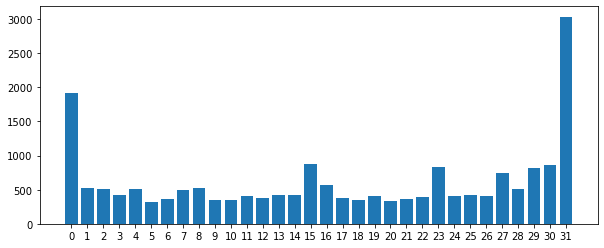

In [1]:
import data_extract as dae
trainset, valset = dae.read_movielens(entire = True)
from plot import plot_slate_response_distribution
%matplotlib inline
plot_slate_response_distribution(trainset["responses"])

In [3]:
from data_extract import balance_n_click
slates, users, responses = balance_n_click(trainset["features"], trainset["sessions"], trainset["responses"])

100%|██████████| 312/312 [00:00<00:00, 61704.21it/s]
0it [00:00, ?it/s]
100%|██████████| 614/614 [00:00<00:00, 55594.47it/s]

Before augmentation: 
(array([0, 1, 2, 3, 4, 5]), array([1919, 2642, 3640, 4265, 4131, 3036]))
Augmenting data for #click == 0
Number of new record: 1173
Augmenting data for #click == 1
Number of new record: 811
Augmenting data for #click == 2
Number of new record: 312
Augmenting data for #click == 3
Number of new record: 0
Augmenting data for #click == 4
Number of new record: 67
Augmenting data for #click == 5
Number of new record: 614
After augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([3092, 3453, 3952, 4265, 4198, 3650]))


## 2. Simulation Environments

Recommendation test environment is provided as user response model p(r|s):

* urm: plain user response model
* urm_p: urm with item positional bias
* urm_p_mr: urm_p with multi-item relations


### 2.1 Create Simulation Environment

In [1]:
import argparse
import data_extract as dae
parser = argparse.ArgumentParser()
parser = dae.add_sim_parse(parser)
parser = dae.add_data_parse(parser)
args = parser.parse_args("")

args.n_user = 1000
args.n_item = 3000
args.dataset = "urmpmr"
args.pbias_min = -0.1
args.pbias_max = 0.1
args.mr_factor = 0.3
# args.balance = True
print(args)

Namespace(balance=False, dataset='urmpmr', mr_factor=0.3, n_item=3000, n_test=10000, n_train=100000, n_user=1000, n_val=10000, nouser=False, pbias_max=0.1, pbias_min=-0.1, s=5, sim_dim=8, sim_root=False)


In [2]:
from my_utils import Logger
logger = Logger("log/sim.txt")
simulator, trainset, valset = dae.load_simulation(args, logger)

dir "log" existed
Log file path:
log/sim.txt+++++++++++++++++++++++
Construct simulation data
	device: cpu
	Creating document latent embedding
		Doc embedding sample: tensor([-0.2238, -0.2920, -0.3232, -0.2132,  0.3595, -0.0097,  0.2984,  0.4330],
       grad_fn=<SelectBackward>)
	Creating user latent embedding
		User embedding sample: tensor([-0.0508,  0.4014,  0.3101,  0.4193,  0.1632, -0.0249, -0.4665,  0.1705],
       grad_fn=<SelectBackward>)
generating training set


  0%|          | 0/30010 [00:00<?, ?it/s]

Guarantee min_user_hist requirement:
Guarantee min_item_hist requirement:


 31%|███       | 18688/59980 [00:00<00:00, 185723.58it/s]

Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 169501.42it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  535,  5767, 16061, 21190, 13228,  3199]))
Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000,)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
generating validation set



100%|██████████| 5998/5998 [00:00<00:00, 157371.67it/s]

Guarantee min_user_hist requirement:
Guarantee min_item_hist requirement:
Generate the remaining data
Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  46,  584, 1605, 2111, 1342,  310]))
Initialize dataset
Slates shape: (10000, 5)
Users shape: (10000,)
Response shape: (10000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
save simulator and generated datasets


### 2.2 Simulation Distribution Made Similar to That of Real-world Data

Run 2.1 with balance=True or run the following after running 2.1 with balance=False:

dir "results" existed


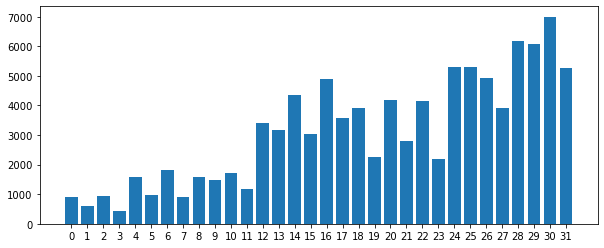

In [3]:
from plot import plot_slate_response_distribution
%matplotlib inline
plot_slate_response_distribution(trainset.responses)

In [4]:
from data_loader import UserSlateResponseDataset
trainset = UserSlateResponseDataset(trainset.slates, trainset.users, trainset.responses, args.nouser)
trainset.balance_n_click()

  0%|          | 0/12830 [00:00<?, ?it/s]

Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000, 1)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
Before augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([  906,  9578, 26780, 35239, 22224,  5273]))
Augmenting data for #click == 0
Number of new record: 17166
Augmenting data for #click == 1
Number of new record: 12830


100%|██████████| 4229/4229 [00:00<00:00, 119688.47it/s]
0it [00:00, ?it/s]
  0%|          | 0/14983 [00:00<?, ?it/s]

Augmenting data for #click == 2
Number of new record: 4229
Augmenting data for #click == 3
Number of new record: 0
Augmenting data for #click == 4
Number of new record: 6507
Augmenting data for #click == 5
Number of new record: 14983


100%|██████████| 14983/14983 [00:00<00:00, 82924.39it/s]


After augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([18072, 22408, 31009, 35239, 28731, 20256]))
Number of records: 155715


dir "results" existed


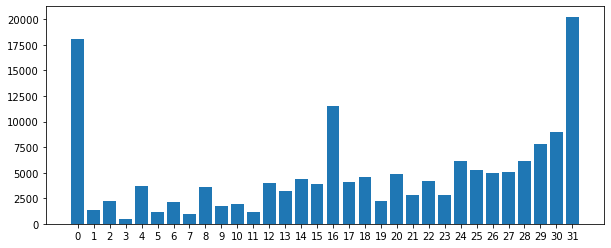

In [5]:
%matplotlib inline
plot_slate_response_distribution(trainset.responses)

### 2.3 Generate More Datasets from Simulator

Run 2.1 first, then run:

In [6]:
users, slates, responses = simulator.generate_dataset(min_user_hist = 10, min_item_hist = 10, n_record = args.n_train)

  0%|          | 0/30010 [00:00<?, ?it/s]

Guarantee min_user_hist requirement:
Guarantee min_item_hist requirement:


 25%|██▍       | 14976/59980 [00:00<00:00, 149011.94it/s]

Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 138542.97it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  534,  5613, 15966, 21369, 13395,  3103]))


### 2.4 Directly Interact with the Environment

In [7]:
import torch
import numpy as np
slates = torch.tensor([np.arange(5), np.arange(5)+5, np.arange(5)+10, np.arange(5)+15])
users = torch.tensor([0,1,2,4])
simulator.forward(slates, users)

tensor([[0.4475, 0.4189, 0.3619, 0.3825, 0.4109],
        [0.6587, 0.5504, 0.3752, 0.8137, 0.4745],
        [0.2670, 0.4182, 0.5624, 0.2035, 0.5300],
        [0.6893, 0.3789, 0.0226, 0.3548, 0.7511]], grad_fn=<AddBackward0>)

In [8]:
simulator.generate_response_for_dataset(users, slates)

100%|██████████| 4/4 [00:00<00:00, 1418.55it/s]


tensor([[0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0],
        [0, 0, 1, 0, 1],
        [1, 0, 0, 0, 1]])

In [1]:
import data_extract as dae
trainset, valset = dae.read_movielens(entire = True)
from plot import plot_slate_response_distribution
%matplotlib inline
plot_slate_response_distribution(trainset["responses"])

Load data from "~/Downloads/data/movielens/test_slate.csv"


FileNotFoundError: [Errno 2] No such file or directory: '~/Downloads/data/movielens/test_slate.csv'

In [2]:
import argparse
import data_extract as dae
parser = argparse.ArgumentParser()
parser = dae.add_sim_parse(parser)
parser = dae.add_data_parse(parser)
args = parser.parse_args("")

args.n_user = 1000
args.n_item = 3000
args.dataset = "urmpmr"
args.pbias_min = -0.1
args.pbias_max = 0.1
args.mr_factor = 0.3
# args.balance = True
print(args)

Namespace(balance=False, dataset='urmpmr', mr_factor=0.3, n_item=3000, n_test=10000, n_train=100000, n_user=1000, n_val=10000, nouser=False, pbias_max=0.1, pbias_min=-0.1, s=5, sim_dim=8, sim_root=False)


In [3]:
from my_utils import Logger
logger = Logger("log/sim.txt")
simulator, trainset, valset = dae.load_simulation(args, logger)

dir "log" existed
Log file path:
log/sim.txt
Construct simulation data
	device: cpu
	Creating document latent embedding
		Doc embedding sample: tensor([-0.0464,  0.0734,  0.1851,  0.0589, -0.1013, -0.4939,  0.3167,  0.2357],
       grad_fn=<SelectBackward>)
	Creating user latent embedding
		User embedding sample: tensor([-0.0978,  0.4087, -0.0497, -0.0296,  0.1272, -0.2747, -0.4952, -0.4937],
       grad_fn=<SelectBackward>)
generating training set
Guarantee min_user_hist requirement:


100%|██████████| 10010/10010 [00:00<00:00, 128308.90it/s]


Guarantee min_item_hist requirement:


100%|██████████| 30010/30010 [00:00<00:00, 197856.03it/s]


Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 173273.94it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  915,  6780, 16437, 20044, 12688,  3116]))
Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000,)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
generating validation set


Guarantee min_user_hist requirement:


100%|██████████| 1001/1001 [00:00<00:00, 126054.53it/s]


Guarantee min_item_hist requirement:


100%|██████████| 3001/3001 [00:00<00:00, 127490.19it/s]


Generate the remaining data


100%|██████████| 5998/5998 [00:00<00:00, 140825.20it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  93,  633, 1634, 2030, 1269,  339]))
Initialize dataset
Slates shape: (10000, 5)
Users shape: (10000,)
Response shape: (10000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
save simulator and generated datasets


FileNotFoundError: [Errno 2] No such file or directory: '../sim_data/urmpmr_dim8_u1000_i3000_n100000_mr0.30_simulator'

In [4]:
from my_utils import Logger
logger = Logger("log/sim.txt")
simulator, trainset, valset = dae.load_simulation(args, logger)

dir "log" existed
Log file path:
log/sim.txt+
Construct simulation data
	device: cpu
	Creating document latent embedding
		Doc embedding sample: tensor([-0.2428,  0.2729, -0.0906, -0.0397,  0.2715, -0.0012,  0.3620,  0.3628],
       grad_fn=<SelectBackward>)
	Creating user latent embedding
		User embedding sample: tensor([ 0.1510, -0.1764, -0.0658, -0.3292,  0.1986,  0.4344,  0.1232, -0.1524],
       grad_fn=<SelectBackward>)
generating training set
Guarantee min_user_hist requirement:


100%|██████████| 10010/10010 [00:00<00:00, 160299.42it/s]


Guarantee min_item_hist requirement:


100%|██████████| 30010/30010 [00:00<00:00, 198339.90it/s]


Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 192465.06it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([ 1102,  6355, 15998, 20760, 12882,  2883]))
Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000,)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
generating validation set


Guarantee min_user_hist requirement:


100%|██████████| 1001/1001 [00:00<00:00, 118254.23it/s]


Guarantee min_item_hist requirement:


100%|██████████| 3001/3001 [00:00<00:00, 133301.28it/s]


Generate the remaining data


100%|██████████| 5998/5998 [00:00<00:00, 149356.36it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  96,  658, 1558, 2135, 1287,  264]))
Initialize dataset
Slates shape: (10000, 5)
Users shape: (10000,)
Response shape: (10000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
save simulator and generated datasets


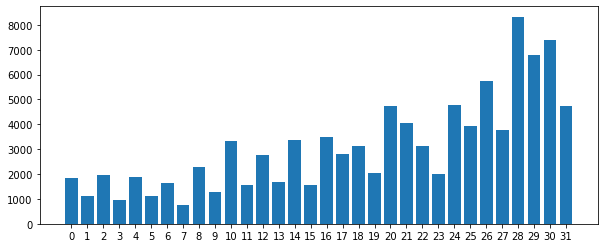

In [5]:
from plot import plot_slate_response_distribution
%matplotlib inline
plot_slate_response_distribution(trainset.responses)

In [6]:
from data_loader import UserSlateResponseDataset
trainset = UserSlateResponseDataset(trainset.slates, trainset.users, trainset.responses, args.nouser)
trainset.balance_n_click()

Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000, 1)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
Before augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([ 1850, 10716, 26592, 34589, 21531,  4722]))
Augmenting data for #click == 0
Number of new record: 16369


100%|██████████| 16369/16369 [00:00<00:00, 143952.50it/s]


Augmenting data for #click == 1
Number of new record: 11936


100%|██████████| 11936/11936 [00:00<00:00, 143620.44it/s]


Augmenting data for #click == 2
Number of new record: 3998


100%|██████████| 3998/3998 [00:00<00:00, 126623.13it/s]


Augmenting data for #click == 3
Number of new record: 0


0it [00:00, ?it/s]


Augmenting data for #click == 4
Number of new record: 6529


100%|██████████| 6529/6529 [00:00<00:00, 113316.88it/s]


Augmenting data for #click == 5
Number of new record: 14933


100%|██████████| 14933/14933 [00:00<00:00, 136913.49it/s]


After augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([18219, 22652, 30590, 34589, 28060, 19655]))
Number of records: 153765


dir "results" existed


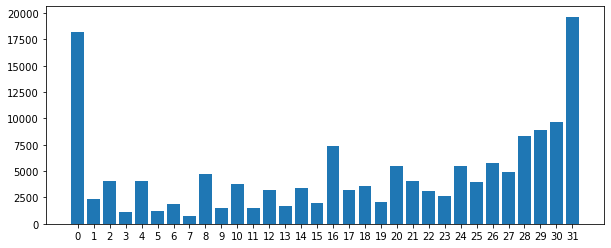

In [7]:
%matplotlib inline
plot_slate_response_distribution(trainset.responses)

In [8]:
users, slates, responses = simulator.generate_dataset(min_user_hist = 10, min_item_hist = 10, n_record = args.n_train)


Guarantee min_user_hist requirement:


100%|██████████| 10010/10010 [00:00<00:00, 130926.90it/s]


Guarantee min_item_hist requirement:


100%|██████████| 30010/30010 [00:00<00:00, 178500.26it/s]


Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 194329.54it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([ 1092,  6448, 16226, 20611, 12849,  2754]))


In [9]:
import torch
import numpy as np
slates = torch.tensor([np.arange(5), np.arange(5)+5, np.arange(5)+10, np.arange(5)+15])
users = torch.tensor([0,1,2,4])
simulator.forward(slates, users)

tensor([[0.7704, 0.4271, 0.6784, 0.3922, 0.1589],
        [0.9676, 0.4235, 0.2330, 0.1899, 0.6408],
        [0.5007, 0.4300, 0.3784, 0.4654, 0.3076],
        [0.6416, 0.6387, 0.4236, 0.5277, 0.3311]], grad_fn=<AddBackward0>)

In [10]:
simulator.generate_response_for_dataset(users, slates)


100%|██████████| 4/4 [00:00<00:00, 891.31it/s]


tensor([[1, 0, 1, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 1, 0, 1, 0]])

In [11]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [1]:
from data_extract import encode_yoochoose
encode_yoochoose()

FileNotFoundError: [Errno 2] No such file or directory: '~/Downloads/data/yoochoose-data/slate_data_size5_min20_train.pkl'

In [1]:
import argparse
import data_extract as dae
parser = argparse.ArgumentParser()
parser = dae.add_sim_parse(parser)
parser = dae.add_data_parse(parser)
args = parser.parse_args("")

args.n_user = 1000
args.n_item = 3000
args.dataset = "urmpmr"
args.pbias_min = -0.1
args.pbias_max = 0.1
args.mr_factor = 0.3
# args.balance = True
print(args)

Namespace(balance=False, dataset='urmpmr', mr_factor=0.3, n_item=3000, n_test=10000, n_train=100000, n_user=1000, n_val=10000, nouser=False, pbias_max=0.1, pbias_min=-0.1, s=5, sim_dim=8, sim_root=False)


In [2]:
from my_utils import Logger
logger = Logger("log/sim.txt")
simulator, trainset, valset = dae.load_simulation(args, logger)

dir "log" existed
Log file path:
log/sim.txt++
Construct simulation data
	device: cpu
	Creating document latent embedding
		Doc embedding sample: tensor([ 0.0333, -0.2621, -0.3908, -0.1742, -0.3231, -0.1833,  0.2616,  0.1933],
       grad_fn=<SelectBackward>)
	Creating user latent embedding
		User embedding sample: tensor([-0.4187, -0.2621,  0.3238, -0.3052,  0.0579,  0.4997,  0.0693, -0.3067],
       grad_fn=<SelectBackward>)
generating training set
Guarantee min_user_hist requirement:


100%|██████████| 10010/10010 [00:00<00:00, 146142.49it/s]


Guarantee min_item_hist requirement:


100%|██████████| 30010/30010 [00:00<00:00, 197919.81it/s]


Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 209587.48it/s]


Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  485,  5131, 16614, 22171, 12948,  2631]))
Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000,)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
generating validation set
Guarantee min_user_hist requirement:


100%|██████████| 1001/1001 [00:00<00:00, 130388.15it/s]


Guarantee min_item_hist requirement:


100%|██████████| 3001/3001 [00:00<00:00, 151436.59it/s]


Generate the remaining data


100%|██████████| 5998/5998 [00:00<00:00, 166388.46it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  54,  513, 1636, 2236, 1286,  273]))
Initialize dataset
Slates shape: (10000, 5)
Users shape: (10000,)
Response shape: (10000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
save simulator and generated datasets


dir "results" existed


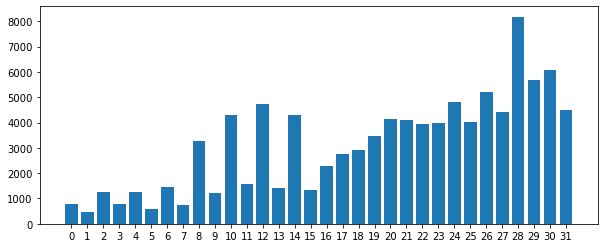

In [3]:
from plot import plot_slate_response_distribution
%matplotlib inline
plot_slate_response_distribution(trainset.responses)

In [4]:
from data_loader import UserSlateResponseDataset
trainset = UserSlateResponseDataset(trainset.slates, trainset.users, trainset.responses, args.nouser)
trainset.balance_n_click()

Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000, 1)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
Before augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([  793,  8551, 27681, 36981, 21500,  4494]))
Augmenting data for #click == 0
Number of new record: 18094


100%|██████████| 18094/18094 [00:00<00:00, 145997.03it/s]


Augmenting data for #click == 1
Number of new record: 14215


100%|██████████| 14215/14215 [00:00<00:00, 154810.55it/s]


Augmenting data for #click == 2
Number of new record: 4650


100%|██████████| 4650/4650 [00:00<00:00, 139047.61it/s]


Augmenting data for #click == 3
Number of new record: 0


0it [00:00, ?it/s]


Augmenting data for #click == 4
Number of new record: 7740


100%|██████████| 7740/7740 [00:00<00:00, 131019.63it/s]


Augmenting data for #click == 5
Number of new record: 16243


100%|██████████| 16243/16243 [00:00<00:00, 134296.24it/s]


After augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([18887, 22766, 32331, 36981, 29240, 20737]))
Number of records: 160942


dir "results" existed


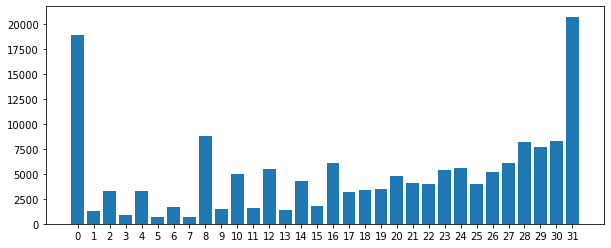

In [5]:

%matplotlib inline
plot_slate_response_distribution(trainset.responses)

In [6]:
users, slates, responses = simulator.generate_dataset(min_user_hist = 10, min_item_hist = 10, n_record = args.n_train)

Guarantee min_user_hist requirement:


100%|██████████| 10010/10010 [00:00<00:00, 153370.36it/s]


Guarantee min_item_hist requirement:


100%|██████████| 30010/30010 [00:00<00:00, 207078.25it/s]


Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 210964.53it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  455,  5091, 16709, 22245, 12742,  2738]))


In [7]:

import torch
import numpy as np
slates = torch.tensor([np.arange(5), np.arange(5)+5, np.arange(5)+10, np.arange(5)+15])
users = torch.tensor([0,1,2,4])
simulator.forward(slates, users)

tensor([[0.3807, 0.3738, 0.2865, 0.5279, 0.4826],
        [0.8945, 0.3836, 1.1829, 0.3720, 0.4024],
        [0.9192, 0.9595, 0.5845, 0.5348, 0.0603],
        [0.4987, 0.5498, 0.6423, 0.5893, 0.3033]], grad_fn=<AddBackward0>)